# US Open Predictions Using XGBoost Model 

After getting into my annual US Open obsession, I decided to try and make the most of my two weeks watching match after match in front of the TV. My enthusiasm for who made it through to the next round to inspired me to try and predict who would win the tournament using this graciously uploaded and recently updated dataset. (I do wish that it included WTA data too, but I found it separately availble for download here: https://github.com/JeffSackmann/tennis_wta). This little project gave me the opportunty to use a model I hadn't used before: XGBoost, or eXtreme Gradient Boosting, and I took some extra time to learn about its inner-workings and will briefly explain them a few scrolls down.

*Note: I ran the model initially before the data was updated with all the US Open matches and before the US Open ended. After it was updated, I excluded the quarterfinals, semifinals, and final matches which I was trying to predict in my simulation.

In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import joblib
import os 
import kagglehub
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

## The data

In [25]:
path = kagglehub.dataset_download("dissfya/atp-tennis-2000-2023daily-pull")
print("Path to dataset files:", path)
path = path +'/atp_tennis.csv'
df_atp = pd.read_csv(path)  # Replace 'your_dataset_file.csv' with the actual file name
df_atp.tail(5)

Path to dataset files: /Users/irisvuko/.cache/kagglehub/datasets/dissfya/atp-tennis-2000-2023daily-pull/versions/855


,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
66222,US Open,2025-09-03,Grand Slam,Outdoor,Hard,Quarterfinals,5,Auger-Aliassime F.,De Minaur A.,Auger-Aliassime F.,27,8,1965,3545,2.20,1.67,4-6 7-6 7-5 7-6
66223,US Open,2025-09-04,Grand Slam,Outdoor,Hard,Quarterfinals,5,Musetti L.,Sinner J.,Sinner J.,10,1,3205,11480,15.00,1.03,1-6 4-6 2-6
66224,US Open,2025-09-05,Grand Slam,Outdoor,Hard,Semifinals,5,Alcaraz C.,Djokovic N.,Alcaraz C.,2,7,9590,4130,1.25,4.00,6-4 7-6 6-2
66225,US Open,2025-09-06,Grand Slam,Outdoor,Hard,Semifinals,5,Auger-Aliassime F.,Sinner J.,Sinner J.,27,1,1965,11480,17.00,1.03,1-6 6-3 3-6 4-6
66226,US Open,2025-09-07,Grand Slam,Outdoor,Hard,The Final,5,Alcaraz C.,Sinner J.,Alcaraz C.,2,1,9590,11480,2.15,1.75,6-2 3-6 6-1 6-4


*Here, I remove anything past the 4th round of the US Open

In [26]:
# Identify the latest tournament
latest_date = df_atp['Date'].max()
latest_tournament = df_atp[df_atp['Date'] == latest_date]['Tournament'].iloc[0]

# Define rounds to keep for the latest tournament
rounds_to_keep = ['1st Round', '2nd Round', '3rd Round', '4th Round']

# - Keep all rows NOT from latest tournament
# - OR if they ARE from latest tournament, then only if round is in rounds_to_keep
mask = (df_atp['Tournament'] != latest_tournament) | (
    (df_atp['Tournament'] == latest_tournament) & (df_atp['Round'].isin(rounds_to_keep))
)

# Apply the mask
df_atp = df_atp[mask]

df_atp.tail(5)


,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
66215,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,Struff J.L.,Djokovic N.,Djokovic N.,144,7,428,4130,5.50,1.14,3-6 3-6 2-6
66216,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,De Minaur A.,Riedi L.,De Minaur A.,8,435,3545,104,1.05,11.00,6-3 6-2 6-1
66217,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,Rublev A.,Auger-Aliassime F.,Auger-Aliassime F.,15,27,2610,1965,1.73,2.10,5-7 3-6 4-6
66218,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,Musetti L.,Munar J.,Musetti L.,10,44,3205,1117,1.44,2.75,6-3 6-0 6-1
66219,US Open,2025-09-02,Grand Slam,Outdoor,Hard,4th Round,5,Bublik A.,Sinner J.,Sinner J.,24,1,2055,11480,8.00,1.08,1-6 1-6 1-6


I decided to keep only the final eight players that were  left in the tournament and set to play quarterfinals as my "active players" who I would have the model focus on learning about.

In [27]:
activeplayers = ['Djokovic N.', 'Alcaraz C.', "Lehecka J.", "Fritz T.", 'De Minaur A.', "Auger-Aliassime F.", "Musetti L.", "Sinner J."]

active_players_df = df_atp[df_atp['Player_1'].isin(activeplayers) | df_atp['Player_2'].isin(activeplayers)]
 
active_players_only_df = df_atp[df_atp['Player_1'].isin(activeplayers) & df_atp['Player_2'].isin(activeplayers)]
active_players_df.tail(5)

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
66215,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,Struff J.L.,Djokovic N.,Djokovic N.,144,7,428,4130,5.50,1.14,3-6 3-6 2-6
66216,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,De Minaur A.,Riedi L.,De Minaur A.,8,435,3545,104,1.05,11.00,6-3 6-2 6-1
66217,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,Rublev A.,Auger-Aliassime F.,Auger-Aliassime F.,15,27,2610,1965,1.73,2.10,5-7 3-6 4-6
66218,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,Musetti L.,Munar J.,Musetti L.,10,44,3205,1117,1.44,2.75,6-3 6-0 6-1
66219,US Open,2025-09-02,Grand Slam,Outdoor,Hard,4th Round,5,Bublik A.,Sinner J.,Sinner J.,24,1,2055,11480,8.00,1.08,1-6 1-6 1-6


I forced my active players to always occupy the Player_1 column so that the model could focus on Player_1. I didn't do this at first, but after some trial and error I realized the model was learning patterns between Player_1 and Player_2 for who was winning more often or who had better stats, so I wanted to remove this confounding factor since there was no correlation between player number and winner.

In [28]:
def force_active_as_p1(df, active_players):
    df_forced = df.copy()

    paired_columns = [
        ('Player_1', 'Player_2'),
        ('Rank_1', 'Rank_2'),
        ('Pts_1', 'Pts_2'),
        ('Odd_1', 'Odd_2'),
    ]

    for idx in df.index:
        p1 = df_forced.at[idx, 'Player_1']
        p2 = df_forced.at[idx, 'Player_2']
        winner = df_forced.at[idx, 'Winner']

        # Swap if Player 2 is active and Player 1 is not
        if p2 in active_players and p1 not in active_players:
            # Swap all paired columns
            for col1, col2 in paired_columns:
                df_forced.at[idx, col1], df_forced.at[idx, col2] = df_forced.at[idx, col2], df_forced.at[idx, col1]
                
    return df_forced


I mapped my active players to ID numbers between 0-7 to be identifiable by the model.

In [29]:
all_players = set(active_players_df['Player_1']).union(set(active_players_df['Player_2']))

# Create player to ID map for all players (active and non-active)
player_map = {name: i for i, name in enumerate(sorted(all_players))}

active_players_df = active_players_df.copy()

active_players_df = force_active_as_p1(active_players_df, activeplayers)

active_player_map = {}
for idx, name in enumerate(sorted(activeplayers)):
    player_map[name] = idx  # Force active players to have 0...N labels
    active_player_map[name] = idx

# Map players to IDs
active_players_df['Player_1_ID'] = active_players_df['Player_1'].map(player_map)
active_players_df['Player_2_ID'] = active_players_df['Player_2'].map(player_map)
active_players_df['Winner_ID'] = active_players_df['Winner'].map(player_map)

# Convert IDs to int (they will be ints already if mapped correctly)
active_players_df['Player_1_ID'] = active_players_df['Player_1_ID'].astype(int)
active_players_df['Player_2_ID'] = active_players_df['Player_2_ID'].astype(int)
active_players_df['Winner_ID'] = active_players_df['Winner_ID'].astype(int)

active_players_df.tail(5)

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score,Player_1_ID,Player_2_ID,Winner_ID
66215,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,Djokovic N.,Struff J.L.,Djokovic N.,7,144,4130,428,1.14,5.50,3-6 3-6 2-6,3,402,3
66216,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,De Minaur A.,Riedi L.,De Minaur A.,8,435,3545,104,1.05,11.00,6-3 6-2 6-1,2,352,2
66217,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,Auger-Aliassime F.,Rublev A.,Auger-Aliassime F.,27,15,1965,2610,2.10,1.73,5-7 3-6 4-6,1,362,1
66218,US Open,2025-09-01,Grand Slam,Outdoor,Hard,4th Round,5,Musetti L.,Munar J.,Musetti L.,10,44,3205,1117,1.44,2.75,6-3 6-0 6-1,6,308,6
66219,US Open,2025-09-02,Grand Slam,Outdoor,Hard,4th Round,5,Sinner J.,Bublik A.,Sinner J.,1,24,11480,2055,1.08,8.00,1-6 1-6 1-6,7,52,7


## The features

Here I am going to list the features, the way they are calculated, and their significance. I changed the features many times and could probably change them many more times to see if I could get better results using different features, but for now I'll leave it at this. 

**Years since**: The years that have passed since this match occurred to learn about its  relevance to the present. Of course Djokovic was winning everything a few years ago, but it is more relevant that Alcaraz and Sinner are winning everything now. 

**Win rate**: The overall win rate for all surfaces and all matches of the past year, aka from the start of this season in January up until now. Divide the number of wins by all the matches of the season.

**Surface win rate**: The same as win rate but goes by surface.

**High Impact Wins**: I assigned the tournaments and rounds different values based on their significance which is based on points that players can earn from them. Then I multiplied those values to get match importance, which I used to calculate high impact wins by iterating through the matches and, if it was above the importance threshhold which I set at 20 (ex: 4th round at a Grand Slam), I counted it as a high importance match. It is more important as a player to get farther into a Grand Slam than any other tournament, so I wanted the model to take into account the differences between tournaments and rounds.

**Average Sets Last 7 Days**: aka Fatigue. I defined number of sets in a list that I updated iteratively with matches of that player and it records number of sets, so I just kept the date of the match within the past 7 days and took the average number of sets. The more sets they played in the past week, the more tired they are for the current match, which affects their performance either negatively, or they push through which is impressive. Also, it says how difficult it has been for them to get this far if they were getting through in straight sets or having to struggle more.

**Head2Head Win Rate**: Basically, I first initialized frozen pairs of players to my head_to_head list (frozen so that the order wouldn't matter) only once and then I iteratively update the list with the winner if the pair is in the list or add the pair if it's not in the list. Finally, I get the rate by returning the wins for either player in the pair divided by the total. It's important to take into account the history two specific players have from their previous matches when trying to predict an upcoming match between them. 

In [30]:
#Eventually, I will scale the features in the list
os.makedirs('scalers', exist_ok=True)

df_original = active_players_df.copy()

features_to_scale = ['HighImpWins_P1', 'HighImpWins_Diff',
                     'Years_since']

scaler = MinMaxScaler()

# Convert date column to datetime if not done already
df_original['Date'] = pd.to_datetime(df_original['Date'])

# Rank diff
df_original['Rank_Diff'] = df_original['Rank_1'] - df_original['Rank_2']

# Years since match
df_original['Date'] = pd.to_datetime(df_original['Date'])
df_original['Years_since'] = 2025 - df_original['Date'].dt.year

# Sort dataframe by date ascending to process features in order
df_original = df_original.sort_values('Date').reset_index(drop=True)

In [31]:
# Get all players list
all_players = set(df_original['Player_1']).union(set(df_original['Player_2']))
activeplayers_set = set(activeplayers)

# Initialize dictionaries to keep track of match history and stats for each player
player_matches = {p: [] for p in all_players}  # stores (date, opponent, did_win, opponent_rank)

def calc_winrate(player, current_date):
    matches = player_matches[player]

    # Get Jan 1st of the current year
    start_of_year = datetime(current_date.year, 1, 1)

    # Only include matches between Jan 1 and current_date 
    recent_matches = [m for m in matches if start_of_year <= m[0] < current_date]

    if len(recent_matches) == 0:
        return 0.0  # No matches this year up to current date

    wins = sum(m[2] for m in recent_matches)  # m[2] is 1 if win, 0 if loss
    winrate = wins / len(recent_matches)

    return winrate

In [32]:
# Surface win rate for each player
# We'll keep track of wins and matches per surface too
player_surface_stats = {p: {} for p in all_players}  # {surface: (wins, total)}

df_original['Surface'] = df_original['Surface'].astype(str)
df_original['Surface'] = df_original['Surface'].fillna('Unknown')


def calc_surface_winrate(player, surface, reference_date=None):
    if reference_date is None:
        reference_date = pd.Timestamp.today()

    one_year_ago = reference_date - pd.Timedelta(days=365)

    # Filter matches in last year on that surface where player played as Player_1 or Player_2
    mask_surface = df_original['Surface'] == surface
    mask_date = (df_original['Date'] > one_year_ago) & (df_original['Date'] <= reference_date)
    mask_player = (df_original['Player_1'] == player) | (df_original['Player_2'] == player)

    recent_matches = df_original[mask_surface & mask_date & mask_player]

    if recent_matches.empty:
        return 0.0

    # Count wins: player is winner
    wins = recent_matches[recent_matches['Winner'] == player].shape[0]
    total = recent_matches.shape[0]

    return wins / total if total > 0 else 0.0

In [33]:
# This is later used to measure fatigue
def count_sets(score_str):
    if pd.isna(score_str) or not isinstance(score_str, str):
        return 0
    return len(score_str.split())

df_original['Num_Sets'] = df_original['Score'].apply(count_sets)

In [34]:
series_tier_map = {
    'Grand Slam': 5,
    'Masters 1000': 4,
    'Masters Cup': 3.5,
    'Masters': 3.5,
    'ATP500': 3,
    'ATP250': 2,
    'International Gold': 1.5,
    'International': 1,
    'Challenger': 0.5  
}

round_value_map = {
    '1st Round': 1,
    '2nd Round': 2,
    '3rd Round': 3,
    '4th Round': 4,
    'Quarterfinals': 5,
    'Semifinals': 6,
    'The Final': 7,
    'Round Robin': 3  # Approximate for round robin stages
}

df_original['Tournament_Tier'] = df_original['Series'].map(series_tier_map).fillna(1)
df_original['Round_Value'] = df_original['Round'].map(round_value_map).fillna(0)
df_original['Match_Importance'] = df_original['Tournament_Tier'] * df_original['Round_Value']

importance_threshold = 20

# Initialize dict to store wins for each player
player_high_importance_wins = {p: [] for p in all_players}  # (date, cumulative wins)

def get_cumulative_wins(player, current_date):
    wins = player_high_importance_wins[player]
    # Filter only wins before current_date
    past_wins = [win_date for win_date in wins if win_date < current_date]
    return len(past_wins)

In [35]:
def avg_sets_last_7_days(player, current_date):
    matches = player_matches[player]
    recent = [m for m in matches if (current_date - m[0]).days <= 7]
    
    if not recent:
        return 0.0
    
    avg_sets = np.mean([m[4] for m in recent])  # m[4] = num_sets
    return avg_sets

In [36]:
# Global H2H dictionary
head_to_head = {}

def initialize_head_to_head(df):
    for _, row in df.iterrows():
        p1 = row['Player_1']
        p2 = row['Player_2']
        winner = row['Winner']

        # Use frozenset to make the key unordered
        pair = frozenset([p1, p2])

        # Initialize H2H entry if not already present
        if pair not in head_to_head:
            head_to_head[pair] = {p1: 0, p2: 0}

        # Update winner count (only if winner is either p1 or p2)
        if winner == p1 or winner == p2:
            head_to_head[pair][winner] += 1
        else:
            print(f"Warning: Winner '{winner}' does not match players '{p1}' or '{p2}' in row {_}")

def update_head_to_head(p1, p2, winner):
    pair = frozenset([p1, p2])
    if pair not in head_to_head:
        head_to_head[pair] = {p1: 0, p2: 0}
    if winner in head_to_head[pair]:
        head_to_head[pair][winner] += 1
    else:
        print(f"Warning: Winner '{winner}' not found in pair {pair}")

def get_head_to_head_stats(p1, p2):
    pair = frozenset([p1, p2])
    if pair in head_to_head:
        wins_p1 = head_to_head[pair].get(p1, 0)
        wins_p2 = head_to_head[pair].get(p2, 0)
        total = wins_p1 + wins_p2
        if total > 0:
            return wins_p1 / total, wins_p2 / total
    return 0.0, 0.0

In [37]:
# Pre-define all columns that will be updated in the loop
df_original['WinRate_Last365_P1'] = 0.0
df_original['WinRate_Last365_P2'] = 0.0
df_original['SurfaceWinRate_P1'] = 0.0
df_original['SurfaceWinRate_P2'] = 0.0
df_original['H2H_WinRate_P1'] = 0.0
df_original['H2H_WinRate_P2'] = 0.0
df_original['HighImpWins_P1'] = 0
df_original['HighImpWins_P2'] = 0
df_original['AvgSets_Last7_P1'] = 0.0
df_original['AvgSets_Last7_P2'] = 0.0

# Loop
for idx, row in df_original.iterrows():
    date = row['Date']
    p1 = row['Player_1']
    p2 = row['Player_2']
    winner = row['Winner']
    surface = row['Surface']
    rank_p1 = row['Rank_1']
    rank_p2 = row['Rank_2']
    importance = row['Match_Importance']
    num_sets = row['Num_Sets']
    
    # Feature Calculation (before updating match history)
    
    # Win rate this year
    winrate_p1 = calc_winrate(p1, date)
    winrate_p2 = calc_winrate(p2, date)
    df_original.at[idx, 'WinRate_Last365_P1'] = winrate_p1
    df_original.at[idx, 'WinRate_Last365_P2'] = winrate_p2

    # Surface win rate
    surf_winrate_p1 = calc_surface_winrate(p1, surface, date)
    surf_winrate_p2 = calc_surface_winrate(p2, surface, date)
    df_original.at[idx, 'SurfaceWinRate_P1'] = surf_winrate_p1
    df_original.at[idx, 'SurfaceWinRate_P2'] = surf_winrate_p2

    # Avg sets in last 7 days (fatigue)
    avg_sets_p1 = avg_sets_last_7_days(p1, date)
    avg_sets_p2 = avg_sets_last_7_days(p2, date)
    df_original.at[idx, 'AvgSets_Last7_P1'] = avg_sets_p1
    df_original.at[idx, 'AvgSets_Last7_P2'] = avg_sets_p2

    # Head-to-head
    h2h_winrate_p1, h2h_winrate_p2 = get_head_to_head_stats(p1, p2)
    df_original.at[idx, 'H2H_WinRate_P1'] = h2h_winrate_p1
    df_original.at[idx, 'H2H_WinRate_P2'] = h2h_winrate_p2

    # High importance wins before this match
    df_original.at[idx, 'HighImpWins_P1'] = get_cumulative_wins(p1, date)
    df_original.at[idx, 'HighImpWins_P2'] = get_cumulative_wins(p2, date)

    # Update Match Histories (after feature calculation)

    # Update match history for win rate + fatigue
    did_p1_win = winner == p1
    did_p2_win = winner == p2

    player_matches[p1].append((date, p2, int(did_p1_win), rank_p2, num_sets))
    player_matches[p2].append((date, p1, int(did_p2_win), rank_p1, num_sets))

    # Update surface stats
    for player, did_win in [(p1, did_p1_win), (p2, did_p2_win)]:
        if surface not in player_surface_stats[player]:
            player_surface_stats[player][surface] = [0, 0]
        if did_win:
            player_surface_stats[player][surface][0] += 1
        player_surface_stats[player][surface][1] += 1

    # Update high importance win list
    if importance > importance_threshold:
        if winner == p1:
            player_high_importance_wins[p1].append(date)
        elif winner == p2:
            player_high_importance_wins[p2].append(date)

    # Update head-to-head stats
    update_head_to_head(p1, p2, winner)

# After loop: Calculate differences
df_original['WinRate_Last365_Diff'] = df_original['WinRate_Last365_P1'] - df_original['WinRate_Last365_P2']
df_original['SurfaceWinRate_Diff'] = df_original['SurfaceWinRate_P1'] - df_original['SurfaceWinRate_P2']
df_original['AvgSets_Last7_Diff'] = df_original['AvgSets_Last7_P1'] - df_original['AvgSets_Last7_P2']
df_original['H2H_WinRate_Diff'] = df_original['H2H_WinRate_P1'] - df_original['H2H_WinRate_P2']
df_original['HighImpWins_Diff'] = df_original['HighImpWins_P1'] - df_original['HighImpWins_P2']

scaler = MinMaxScaler()
df_original[features_to_scale] = scaler.fit_transform(df_original[features_to_scale])
joblib.dump(scaler, 'scalers/core_features_scaler.pkl')

['scalers/core_features_scaler.pkl']

*Note: (ABOUT SCALING) I scaled Years since because most of my other features were on a much smaller scale, but Years since was up to 20 years, so it dominated over my other features. I scaled High Impact Wins because sometimes it was a huge difference and most of the other features were much smaller, so I wanted to normalize it. The rest of the features are naturally on a normal scale and some of them I chose not to scale, like Rank Difference or Head to Head win rate because, although they can be high numbers, I do think they are meaningful enough for the model to focus on in the cases that they happen to be very large.

Again, this is something I could experiment with more but I'm leaving it for now.

Just a check to compare my rates with the official ATP website. Here I'm close enough but not exact...

In [39]:
current_date = pd.to_datetime("2025-09-01")  # or the date of the match being predicted
winratej = calc_winrate("Sinner J.", current_date)
winraten = calc_winrate("Djokovic N.", current_date)
winratec = calc_winrate("Alcaraz C.", current_date)
winratef = calc_winrate("Auger-Aliassime F.", current_date)
winratea = calc_winrate("De Minaur A.", current_date)
winratet = calc_winrate("Fritz T.", current_date)
winratel = calc_winrate("Lehecka J.", current_date)
winratem = calc_winrate("Musetti L.", current_date)
surfratej = calc_surface_winrate("Sinner J.", "Grass", current_date)
surfratec = calc_surface_winrate("Alcaraz C.", "Clay", current_date)
winratej

0.9166666666666666

Another check to make sure win rates are aligning with official ATP website. All good.

In [40]:
def print_head_to_heads(matches):
    print("Head-to-Head winrates:")
    for p1, p2 in matches:
        h2h_p1, h2h_p2 = get_head_to_head_stats(p1, p2)
        print(f"  {p1} vs {p2}:")
        print(f"    - {p1} H2H winrate: {h2h_p1*100:.2f}%")
        print(f"    - {p2} H2H winrate: {h2h_p2*100:.2f}%")
    print()

# Use this for your quarterfinals like this:
qf_matches = [
    ("Alcaraz C.", "Lehecka J."),
    ("Djokovic N.", "Fritz T."),
    ("Sinner J.", "Musetti L."),
    ("De Minaur A.", "Auger-Aliassime F."),
    ("Djokovic N.", "Alcaraz C.")
]

print_head_to_heads(qf_matches)

Head-to-Head winrates:
  Alcaraz C. vs Lehecka J.:
    - Alcaraz C. H2H winrate: 66.67%
    - Lehecka J. H2H winrate: 33.33%
  Djokovic N. vs Fritz T.:
    - Djokovic N. H2H winrate: 100.00%
    - Fritz T. H2H winrate: 0.00%
  Sinner J. vs Musetti L.:
    - Sinner J. H2H winrate: 100.00%
    - Musetti L. H2H winrate: 0.00%
  De Minaur A. vs Auger-Aliassime F.:
    - De Minaur A. H2H winrate: 50.00%
    - Auger-Aliassime F. H2H winrate: 50.00%
  Djokovic N. vs Alcaraz C.:
    - Djokovic N. H2H winrate: 57.14%
    - Alcaraz C. H2H winrate: 42.86%



For my final features, I used a lot of differences to get a comparative information and, since my active player is always Player 1, I also used their stats to get activeplayer-specific information.

I filtered the dataframe to have less Djokovc samples because if not, I was worried the model would overfit to him since he had way more appearances than anyone else in my eight active players.

In [41]:
feature_cols = [
    'Rank_1', 'Rank_Diff', 'Years_since',
    'WinRate_Last365_P1', 'WinRate_Last365_Diff',
    'SurfaceWinRate_P1', 'SurfaceWinRate_Diff',
    'AvgSets_Last7_P1','AvgSets_Last7_Diff', 
    'H2H_WinRate_P1', 'H2H_WinRate_Diff', 
    'HighImpWins_P1', 'HighImpWins_Diff'
]

# Only keep rows where the Winner is in active_player_map
df_filtered = df_original[df_original['Winner'].isin(active_player_map.keys())].copy()

# Map Winner to 0–7
df_filtered['y'] = df_filtered['Winner'].map(active_player_map)

df_djokovic = df_filtered[df_filtered['y'] == active_player_map['Djokovic N.']]
df_others = df_filtered[df_filtered['y'] != active_player_map['Djokovic N.']]
df_balanced = pd.concat([
    df_djokovic.sample(n=200, random_state=42),  # or however many you want
    df_others
])

X = df_balanced[feature_cols]
y = df_balanced['Winner_ID']

In [42]:
X

,Rank_1,Rank_Diff,Years_since,WinRate_Last365_P1,WinRate_Last365_Diff,SurfaceWinRate_P1,SurfaceWinRate_Diff,AvgSets_Last7_P1,AvgSets_Last7_Diff,H2H_WinRate_P1,H2H_WinRate_Diff,HighImpWins_P1,HighImpWins_Diff
642,1,-6,0.523810,0.885246,0.885246,0.891304,0.891304,2.000000,2.000000,0.500000,0.000000,0.429952,0.712195
452,1,-20,0.619048,0.900000,0.900000,0.878049,0.878049,2.000000,2.000000,1.000000,1.000000,0.227053,0.609756
554,1,-31,0.571429,0.847826,0.847826,0.895833,0.895833,2.500000,2.500000,1.000000,1.000000,0.342995,0.668293
52,24,9,0.904762,0.687500,0.687500,0.545455,0.545455,0.000000,0.000000,0.000000,0.000000,0.000000,0.495122
745,1,-2,0.428571,1.000000,1.000000,0.936508,0.436508,3.666667,3.666667,0.514286,0.028571,0.570048,0.753659
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3380,2,-80,0.000000,0.900000,0.900000,0.804878,0.804878,3.000000,3.000000,1.000000,1.000000,0.178744,0.585366
3381,27,12,0.000000,0.644444,0.215873,0.676471,0.343137,3.333333,3.333333,0.125000,-0.750000,0.014493,0.495122
3382,10,-34,0.000000,0.717949,0.217949,0.571429,0.321429,3.500000,3.500000,0.333333,-0.333333,0.014493,0.502439
3384,8,-427,0.000000,0.705882,0.705882,0.711111,0.711111,3.000000,3.000000,0.000000,0.000000,0.019324,0.504878


Briefly, XGBoost is a model that uses simpler models, specifically decision trees, and adds trees that correct the mistakes of the previous ones until it gets an accurate prediction. Gradient boosting is in the name, indicating that the algorithm is sequentially combining these decision-tree predictions by minimizing the loss function of the previous tree using gradients, and uses this to adjust the predictions of the new tree. In our case, we use log loss since it is a a classification problem. For each match, it outputs an array of 8 probabilities, since I chose softprob, representing our 8 players, with the highest probability being who is most likely to win the match. I chose to use XGBoost because I was facing a multi-class classification problem. 

Now, I'm not sure if it was the best choice for this problem because once I simulate the US Open, I have 8 probabilities of who will win the two person match, which I then scale to add up to 100%, but I fear that it is maybe redundant to be getting 8 probabilities for my 8 players when 6 of them aren't even participating in any given match. But, I'm happy to have learned about XGBoost and my predictions in the simulation aren't too bad.

(I found these Medium articles about XGBoost very illuminating: https://medium.com/@prathameshsonawane/xgboost-how-does-this-work-e1cae7c5b6cb and https://medium.com/sfu-cspmp/xgboost-a-deep-dive-into-boosting-f06c9c41349)

I could maybe also add a validation split in the future.

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
import xgboost as xgb 
from sklearn.metrics import accuracy_score 
from sklearn.utils.class_weight import compute_sample_weight 

weights = compute_sample_weight(class_weight='balanced', y=y_train) 
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights) 
dtest = xgb.DMatrix(X_test, label=y_test) 

params = {
    'objective': 'multi:softprob',
    'num_class': len(activeplayers),
    'eval_metric': 'mlogloss',
    'seed': 42,
    'verbosity': 1,
    'booster': 'dart',
    'lambda': 1,
    'alpha': 0.5,
    'max_depth': 6, #was 4 initially
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

evals = [(dtrain, 'train'), (dtest, 'eval')] 
bst = xgb.train(params, dtrain, num_boost_round=500, evals=evals, early_stopping_rounds=20) 
y_pred_prob = bst.predict(dtest) 
y_pred = y_pred_prob.argmax(axis=1) 
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2f}") 

[0]	train-mlogloss:1.49804	eval-mlogloss:1.59440
[1]	train-mlogloss:1.20487	eval-mlogloss:1.34611
[2]	train-mlogloss:1.00497	eval-mlogloss:1.15163
[3]	train-mlogloss:0.86254	eval-mlogloss:1.03609
[4]	train-mlogloss:0.75302	eval-mlogloss:0.93791
[5]	train-mlogloss:0.66988	eval-mlogloss:0.86816
[6]	train-mlogloss:0.59951	eval-mlogloss:0.79807
[7]	train-mlogloss:0.54194	eval-mlogloss:0.75393
[8]	train-mlogloss:0.49193	eval-mlogloss:0.70796
[9]	train-mlogloss:0.45051	eval-mlogloss:0.67247
[10]	train-mlogloss:0.40736	eval-mlogloss:0.63229
[11]	train-mlogloss:0.37487	eval-mlogloss:0.60264
[12]	train-mlogloss:0.34694	eval-mlogloss:0.57828
[13]	train-mlogloss:0.31767	eval-mlogloss:0.55219
[14]	train-mlogloss:0.29554	eval-mlogloss:0.52875
[15]	train-mlogloss:0.27885	eval-mlogloss:0.51603
[16]	train-mlogloss:0.26435	eval-mlogloss:0.50550
[17]	train-mlogloss:0.24685	eval-mlogloss:0.48438
[18]	train-mlogloss:0.23316	eval-mlogloss:0.47177
[19]	train-mlogloss:0.21974	eval-mlogloss:0.45811
[20]	train

After training my XGBoost model, I have pretty high accuracy and some overfitting. I could adjust parameters like early stopping or depth (amount of splits per tree) more, but for now I'll leave it. Confusion matrix looks good, player distribution checks out, and feature importance is mostly focused on high importance wins of my active player, the difference between high importance wins, and years since. The former make sense to me as an important feature, but I'm not sure about years since or if that will be helpful when it comes to predicting the U.S. Open outcomes.

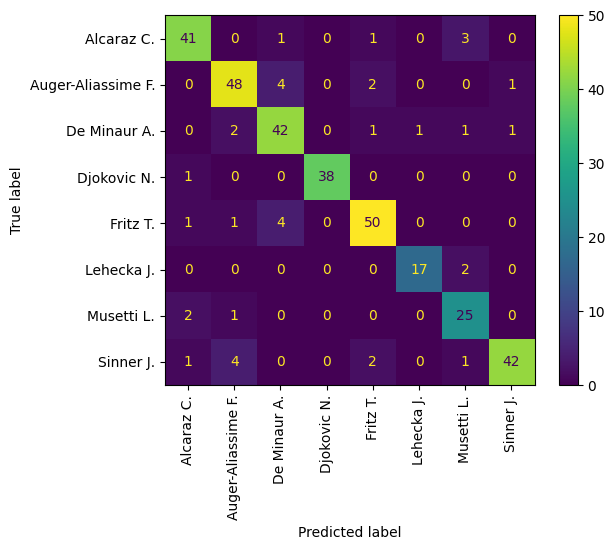

In [45]:
cm = confusion_matrix(y_test, y_pred)

# Reverse the mapping: from ID to name
id_to_player = {v: k for k, v in active_player_map.items()}

# Create a list of display labels ordered by class ID (i.e., 0 to 7)
sorted_labels = [id_to_player[i] for i in range(len(id_to_player))]

# Then use this in the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted_labels)
disp.plot(xticks_rotation='vertical')

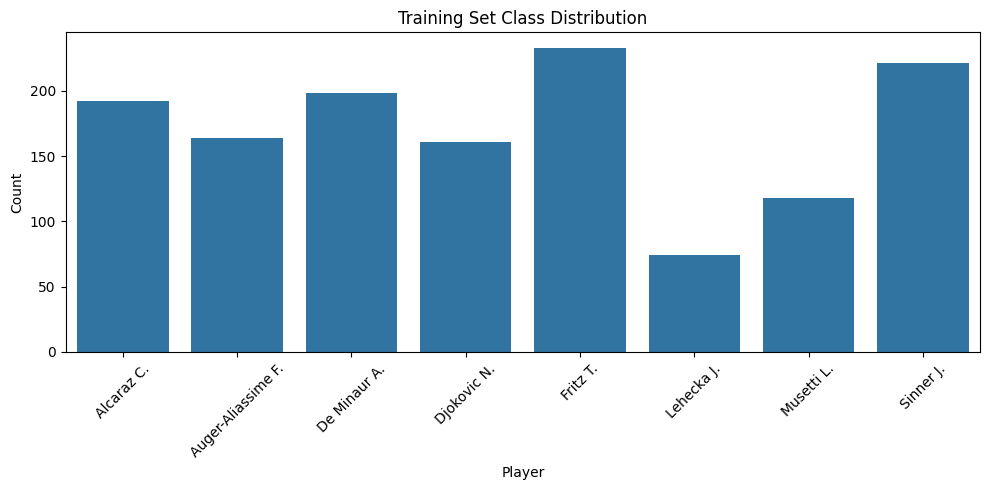

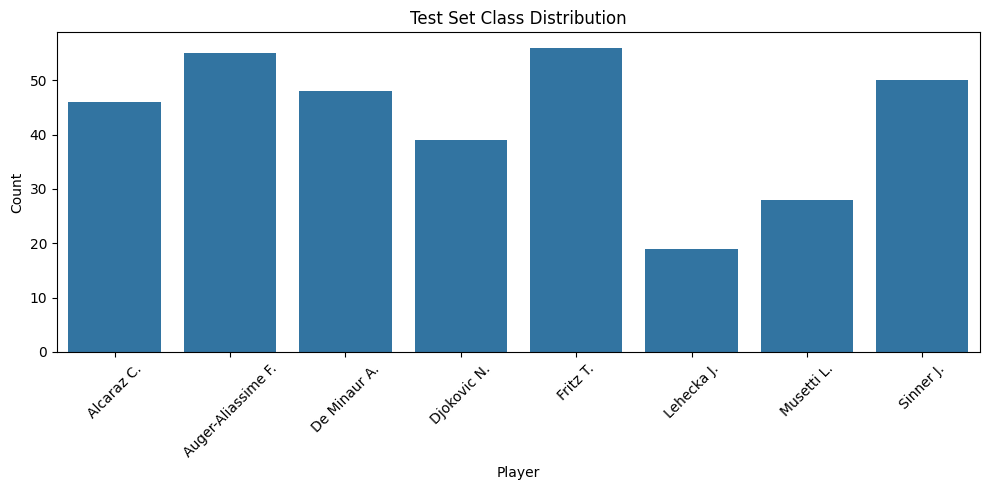

In [46]:
ordered_player_names = [id_to_player[i] for i in sorted(id_to_player.keys())]

# Map numeric labels to player names
y_train_named = y_train.map(id_to_player)
y_test_named = y_test.map(id_to_player)

# Plot training distribution
plt.figure(figsize=(10,5))
sns.countplot(x=y_train_named, order=ordered_player_names)
plt.title("Training Set Class Distribution")
plt.xlabel("Player")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot test distribution
plt.figure(figsize=(10,5))
sns.countplot(x=y_test_named, order=ordered_player_names)
plt.title("Test Set Class Distribution")
plt.xlabel("Player")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Once again, not sure how I feel about the model relying on "Years since" so much, but when I removed it as a feature my accuracy went way down, so it must be learning something useful from that.

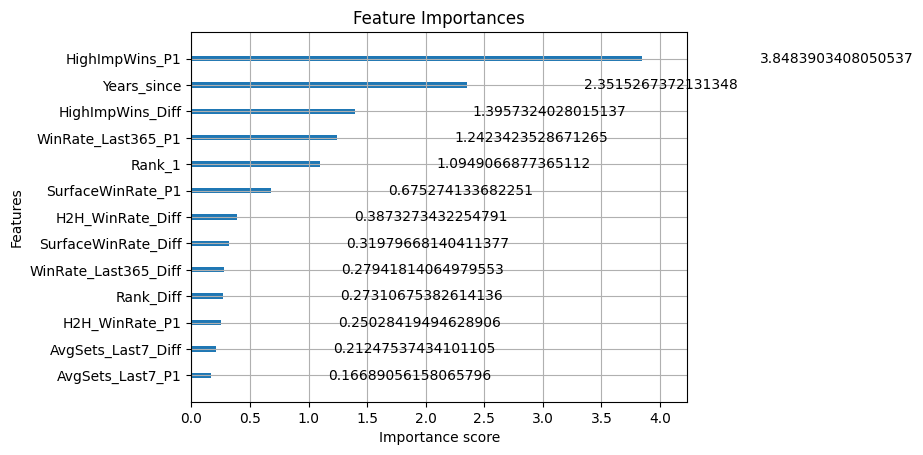

In [48]:
xgb.plot_importance(bst, importance_type='gain')
plt.title("Feature Importances")
plt.show()

## Simulate US open

I simulate the US Open by creating a function to simulate single matches using my trained model and the same features I used to train it. It basically builds a mini dataset with one row (one match) with only information about the two players in the match and using only their stats to build the features. Then I simulate the quarterfinals, the semifinals, and the finals. 

I do update the data with my predictions for the winner of each match, which may be controversial, but I believe it makes sense for this purpose. Although my predictions are not necessarily accurate, I think this maintains the integrity of the simulated US Open to use the fake match results in predicting the following ones.

Maybe there is a way to use the updated dataset to compare my prediction for quarterfinals and semifinals with the true winners and, if it is correct, update the dataset with it and, if not, use the true data.

The way I made the probabilities binary and removed the noise of the other 6 players who aren't in the match is by taking the logits, raw scores the model outputs before I convert them into probabilities, of the two players who are in the match. Then I apply a temperature scaling factor to the difference in order to make my model less certain, since I found it to be overconfident sometimes, and finally apply sigmoid (since it's two players aka binary and not eight) to those values in order to get my two probabilities.

In [49]:
def simulate_match(p1, p2, match_date, surface='Hard', round_name='Quarterfinals', best_of=5):
    # --- Calculate features for this match ---
    rank_1 = 999
    rank_2 = 999
    rank_1 = df_original[df_original['Player_1'] == p1]['Rank_1'].iloc[-1] if not df_original[df_original['Player_1'] == p1].empty else rank_1
    rank_2 = df_original[df_original['Player_2'] == p2]['Rank_2'].iloc[-1] if not df_original[df_original['Player_2'] == p2].empty else rank_2
    rankdiff = rank_2 - rank_1

    years_since = 2025 - match_date.year

    winrate_p1 = calc_winrate(p1, match_date)
    winrate_p2 = calc_winrate(p2, match_date)
    winrate_diff = winrate_p1 - winrate_p2
    surface_winrate_p1 = calc_surface_winrate(p1, surface)
    surface_winrate_p2 = calc_surface_winrate(p2, surface)
    surface_winrate_diff = surface_winrate_p1 - surface_winrate_p2
    avg_sets_p1 = avg_sets_last_7_days(p1, match_date)
    avg_sets_p2 = avg_sets_last_7_days(p2, match_date)
    avg_sets_diff = avg_sets_p1 - avg_sets_p2
    h2h_winrate_p1, h2h_winrate_p2 = get_head_to_head_stats(p1, p2)


    high_imp_wins_p1 = get_cumulative_wins(p1, match_date)
    high_imp_wins_p2 = get_cumulative_wins(p2, match_date)
    high_imp_wins_diff = high_imp_wins_p1 - high_imp_wins_p2

    tournament_tier = series_tier_map.get('Grand Slam', 5)
    round_val = round_value_map.get(round_name, 5)
    match_importance = tournament_tier * round_val
    num_sets = best_of

 
    # --- Create DataFrame with features ---
    row = pd.DataFrame([{
        'Rank_1': rank_1,
        'Rank_Diff': rankdiff,
        'Years_since': years_since,
        'WinRate_Last365_P1': winrate_p1,
        'WinRate_Last365_Diff': winrate_diff,
        'SurfaceWinRate_P1': surface_winrate_p1,
        'SurfaceWinRate_Diff': surface_winrate_diff,
        'HighImpWins_P1': high_imp_wins_p1,
        'AvgSets_Last7_P1': avg_sets_p1,
        'AvgSets_Last7_Diff': avg_sets_diff,
        'H2H_WinRate_P1': h2h_winrate_p1,
        'H2H_WinRate_Diff': h2h_winrate_p1 - h2h_winrate_p2,
        'HighImpWins_Diff': high_imp_wins_diff
    }])

    core_scaler = joblib.load('scalers/core_features_scaler.pkl')

    row[['HighImpWins_P1', 'HighImpWins_Diff', 'Years_since']] = core_scaler.transform(
    row[['HighImpWins_P1', 'HighImpWins_Diff','Years_since']]
)

    # --- Print feature inputs for debugging ---
    print(f"\nFeatures for {p1} vs {p2}:")
    for col in row.columns:
        print(f"  {col}: {row[col].iloc[0]}")
    

    dmatch = xgb.DMatrix(row[feature_cols])

    # Map player names to indices
    p1_idx = active_player_map[p1]
    p2_idx = active_player_map[p2]

    # Adjusting probabilities
    logits = bst.predict(dmatch, output_margin=True)[0]  # raw scores before sigmoid 
    temperature = 2.5
    score_diff = (logits[p1_idx] - logits[p2_idx]) / temperature
    p1_prob = 1 / (1 + np.exp(-score_diff))  # Sigmoid
    p2_prob = 1 - p1_prob

    print(f"🔍 Probabilities for {p1} vs {p2}:")
    print(f"→ {p1}: {p1_prob * 100:.2f}%")
    print(f"→ {p2}: {p2_prob * 100:.2f}%")

    # Predict winner based on higher probability
    predicted_winner = p1 if p1_prob > p2_prob else p2
    loser = p2 if predicted_winner == p1 else p1

    # --- Update history dicts (important!) ---
    did_p1_win = int(predicted_winner == p1)
    did_p2_win = int(predicted_winner == p2)

    # Update match history
    player_matches[p1].append((match_date, p2, did_p1_win, rank_2, num_sets))
    player_matches[p2].append((match_date, p1, did_p2_win, rank_1, num_sets))

    # Update surface stats
    for player, did_win in [(p1, did_p1_win), (p2, did_p2_win)]:
        if surface not in player_surface_stats[player]:
            player_surface_stats[player][surface] = [0, 0]
        player_surface_stats[player][surface][0] += did_win
        player_surface_stats[player][surface][1] += 1
    
    initialize_head_to_head(df_original)

    # Update H2H
    update_head_to_head(p1, p2, predicted_winner)

    # Update high importance wins
    if match_importance > importance_threshold:
        player_high_importance_wins[predicted_winner].append(match_date)

    return predicted_winner


In [50]:
def run_us_open_simulation():
    current_date = pd.to_datetime("2025-9-2")
    surface = "Hard"
    best_of = 5

    print("Quarterfinals")
    qf_matches = [
        ("Alcaraz C.", "Lehecka J."),
        ("Djokovic N.", "Fritz T."),
        ("Sinner J.", "Musetti L."),
        ("De Minaur A.", "Auger-Aliassime F.")
    ]

    qf_winners = []
    for p1, p2 in qf_matches:
        winner = simulate_match(p1, p2, current_date, surface, 'Quarterfinals', best_of)
        print(f"{p1} vs {p2} → Winner: {winner}")
        qf_winners.append(winner)

    print("\nSemifinals")
    sf_matches = [
        (qf_winners[0], qf_winners[1]),
        (qf_winners[2], qf_winners[3])
    ]

    sf_winners = []
    for p1, p2 in sf_matches:
        winner = simulate_match(p1, p2, current_date + pd.Timedelta(days=2), surface, 'Semifinals', best_of)
        print(f"{p1} vs {p2} → Winner: {winner}")
        sf_winners.append(winner)

    print("\nFinal")
    final_winner = simulate_match(
        sf_winners[0], sf_winners[1], current_date + pd.Timedelta(days=4), surface, 'The Final', best_of
    )
    print(f"Final: {sf_winners[0]} vs {sf_winners[1]} → Champion: {final_winner}")

    return final_winner


In [51]:
champion = run_us_open_simulation()

Quarterfinals

Features for Alcaraz C. vs Lehecka J.:
  Rank_1: 2
  Rank_Diff: 25
  Years_since: 0.0
  WinRate_Last365_P1: 0.9016393442622951
  WinRate_Last365_Diff: 0.2571948998178506
  SurfaceWinRate_P1: 0.8048780487804879
  SurfaceWinRate_Diff: 0.14634146341463417
  HighImpWins_P1: 0.178743961352657
  AvgSets_Last7_P1: 3.0
  AvgSets_Last7_Diff: -0.6666666666666665
  H2H_WinRate_P1: 0.6666666666666666
  H2H_WinRate_Diff: 0.3333333333333333
  HighImpWins_Diff: 0.5853658536585366
🔍 Probabilities for Alcaraz C. vs Lehecka J.:
→ Alcaraz C.: 95.09%
→ Lehecka J.: 4.91%
Alcaraz C. vs Lehecka J. → Winner: Alcaraz C.

Features for Djokovic N. vs Fritz T.:
  Rank_1: 7
  Rank_Diff: 0
  Years_since: 0.0
  WinRate_Last365_P1: 0.7837837837837838
  WinRate_Last365_Diff: 0.06949806949806947
  SurfaceWinRate_P1: 0.8076923076923077
  SurfaceWinRate_Diff: 0.14915572232645402
  HighImpWins_P1: 1.0
  AvgSets_Last7_P1: 3.6666666666666665
  AvgSets_Last7_Diff: 0.0
  H2H_WinRate_P1: 1.0
  H2H_WinRate_Diff: 

There is one mistake where the model predicts that De Minaur beats Auger-Aliassime, when in fact he did not, but other than that the rest are good. Yay

Feature importance (gain):
HighImpWins_P1: 3.8484
Years_since: 2.3515
HighImpWins_Diff: 1.3957
WinRate_Last365_P1: 1.2423
Rank_1: 1.0949
SurfaceWinRate_P1: 0.6753
H2H_WinRate_Diff: 0.3873
SurfaceWinRate_Diff: 0.3198
WinRate_Last365_Diff: 0.2794
Rank_Diff: 0.2731
H2H_WinRate_P1: 0.2503
AvgSets_Last7_Diff: 0.2125
AvgSets_Last7_P1: 0.1669


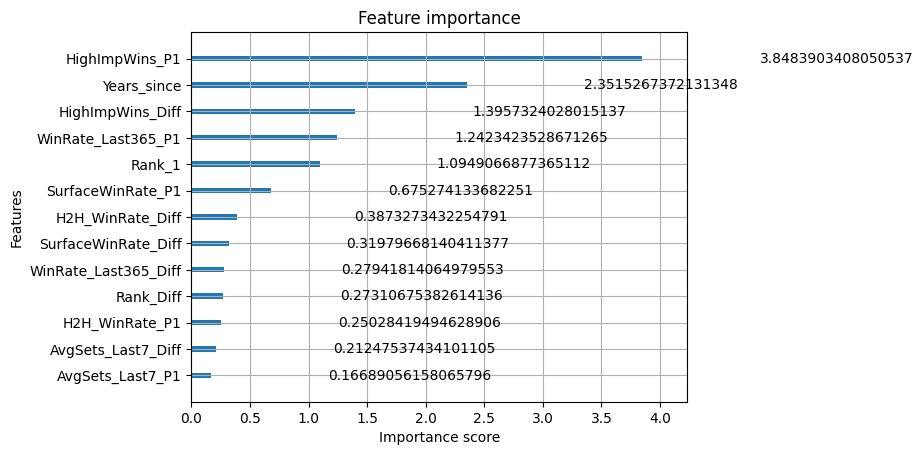

In [52]:
# Get feature importance scores as a dictionary
importance = bst.get_score(importance_type='weight')  

# Or use 'gain' to see average gain of splits which is more informative
importance_gain = bst.get_score(importance_type='gain')

# Sort and print
importance_sorted = sorted(importance_gain.items(), key=lambda x: x[1], reverse=True)

print("Feature importance (gain):")
for feature, score in importance_sorted:
    print(f"{feature}: {score:.4f}")

xgb.plot_importance(bst, importance_type='gain')
plt.show()


Now I want to see if using only matches in the dataset that are between two of my active players will affect the model's predictions in my simulation. I believe it will lower my accuracy since there will be way less samples, but let's see...

## H2H Matches Only

I'm going to do everything the same, but I'm using my active_players_only_df datset that I created at the beginning which only includes matches that both of my active players are in.

Another difference is that I won't be forcing my active player to be Player_1 because both of the players are active, and I will use the same features as before PLUS Player_2 features, which makes sense because both players are now relevant. Also, maybe more features will be useful since the model will be working with less samples now.

In [53]:
all_players = set(active_players_df['Player_1']).union(set(active_players_df['Player_2']))

# Create player to ID map for all players (active and non-active)
player_map = {name: i for i, name in enumerate(sorted(all_players))}

active_players_only_df = active_players_only_df.copy()

active_player_map = {}
for idx, name in enumerate(sorted(activeplayers)):
    player_map[name] = idx  # Force active players to have 0...N labels
    active_player_map[name] = idx

# Map players to IDs
active_players_only_df['Player_1_ID'] = active_players_only_df['Player_1'].map(player_map)
active_players_only_df['Player_2_ID'] = active_players_only_df['Player_2'].map(player_map)
active_players_only_df['Winner_ID'] = active_players_only_df['Winner'].map(player_map)

# Convert IDs to int (they will be ints already if mapped correctly)
active_players_only_df['Player_1_ID'] = active_players_only_df['Player_1_ID'].astype(int)
active_players_only_df['Player_2_ID'] = active_players_only_df['Player_2_ID'].astype(int)
active_players_only_df['Winner_ID'] = active_players_only_df['Winner_ID'].astype(int)

active_players_only_df.tail(5)

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score,Player_1_ID,Player_2_ID,Winner_ID
65702,Wimbledon,2025-07-11,Grand Slam,Outdoor,Grass,Semifinals,5,Sinner J.,Djokovic N.,Sinner J.,1,6,10430,4630,1.40,2.80,6-3 6-3 6-4,7,3,7
65703,Wimbledon,2025-07-13,Grand Slam,Outdoor,Grass,The Final,5,Alcaraz C.,Sinner J.,Sinner J.,2,1,9300,10430,2.00,1.83,6-4 4-6 4-6 4-6,0,7,7
65872,Citi Open,2025-07-24,ATP500,Outdoor,Hard,3rd Round,3,De Minaur A.,Lehecka J.,De Minaur A.,13,25,2885,2015,1.53,2.50,7-6 6-7 6-4,2,5,2
65966,Canadian Open,2025-08-04,Masters 1000,Outdoor,Hard,4th Round,3,Fritz T.,Lehecka J.,Fritz T.,4,27,5135,2015,1.30,3.40,7-6 6-7 7-6,4,5,4
66055,Western & Southern Financial Group Masters,2025-08-14,Masters 1000,Outdoor,Hard,Quarterfinals,3,Auger-Aliassime F.,Sinner J.,Sinner J.,28,1,1825,12030,7.00,1.10,0-6 2-6,1,7,7


Note: I realize I could have wrapped the functions better so I wouldn't have to copy and paste all of this...

In [58]:
#Eventually, I will scale the features in the list
os.makedirs('scalers', exist_ok=True)

df_original = active_players_only_df.copy()

features_to_scale = ['HighImpWins_P1', 'HighImpWins_P2', 'HighImpWins_Diff',
                     'Years_since']

scaler = MinMaxScaler()

# Convert date column to datetime if not done already
df_original['Date'] = pd.to_datetime(df_original['Date'])

# Rank diff
df_original['Rank_Diff'] = df_original['Rank_1'] - df_original['Rank_2']

# Years since match
df_original['Date'] = pd.to_datetime(df_original['Date'])
df_original['Years_since'] = 2025 - df_original['Date'].dt.year

# Sort dataframe by date ascending to process features in order
df_original = df_original.sort_values('Date').reset_index(drop=True)

# Get all players list
all_players = set(df_original['Player_1']).union(set(df_original['Player_2']))
activeplayers_set = set(activeplayers)

# Initialize dictionaries to keep track of match history and stats for each player
player_matches = {p: [] for p in all_players}  # stores (date, opponent, did_win, opponent_rank)

def calc_winrate(player, current_date):
    matches = player_matches[player]

    # Get Jan 1st of the current year
    start_of_year = datetime(current_date.year, 1, 1)

    # Only include matches between Jan 1 and current_date 
    recent_matches = [m for m in matches if start_of_year <= m[0] < current_date]

    if len(recent_matches) == 0:
        return 0.0  # No matches this year up to current date

    wins = sum(m[2] for m in recent_matches)  # m[2] is 1 if win, 0 if loss
    winrate = wins / len(recent_matches)

    return winrate

# Surface win rate for each player
# We'll keep track of wins and matches per surface too
player_surface_stats = {p: {} for p in all_players}  # {surface: (wins, total)}

df_original['Surface'] = df_original['Surface'].astype(str)
df_original['Surface'] = df_original['Surface'].fillna('Unknown')


def calc_surface_winrate(player, surface, reference_date=None):
    if reference_date is None:
        reference_date = pd.Timestamp.today()

    one_year_ago = reference_date - pd.Timedelta(days=365)

    # Filter matches in last year on that surface where player played as Player_1 or Player_2
    mask_surface = df_original['Surface'] == surface
    mask_date = (df_original['Date'] > one_year_ago) & (df_original['Date'] <= reference_date)
    mask_player = (df_original['Player_1'] == player) | (df_original['Player_2'] == player)

    recent_matches = df_original[mask_surface & mask_date & mask_player]

    if recent_matches.empty:
        return 0.0

    # Count wins: player is winner
    wins = recent_matches[recent_matches['Winner'] == player].shape[0]
    total = recent_matches.shape[0]

    return wins / total if total > 0 else 0.0

# This is later used to measure fatigue
def count_sets(score_str):
    if pd.isna(score_str) or not isinstance(score_str, str):
        return 0
    return len(score_str.split())

df_original['Num_Sets'] = df_original['Score'].apply(count_sets)

series_tier_map = {
    'Grand Slam': 5,
    'Masters 1000': 4,
    'Masters Cup': 3.5,
    'Masters': 3.5,
    'ATP500': 3,
    'ATP250': 2,
    'International Gold': 1.5,
    'International': 1,
    'Challenger': 0.5  
}

round_value_map = {
    '1st Round': 1,
    '2nd Round': 2,
    '3rd Round': 3,
    '4th Round': 4,
    'Quarterfinals': 5,
    'Semifinals': 6,
    'The Final': 7,
    'Round Robin': 3  # Approximate for round robin stages
}

df_original['Tournament_Tier'] = df_original['Series'].map(series_tier_map).fillna(1)
df_original['Round_Value'] = df_original['Round'].map(round_value_map).fillna(0)
df_original['Match_Importance'] = df_original['Tournament_Tier'] * df_original['Round_Value']

importance_threshold = 20

# Initialize dict to store wins for each player
player_high_importance_wins = {p: [] for p in all_players}  # (date, cumulative wins)

def get_cumulative_wins(player, current_date):
    wins = player_high_importance_wins[player]
    # Filter only wins before current_date
    past_wins = [win_date for win_date in wins if win_date < current_date]
    return len(past_wins)

def avg_sets_last_7_days(player, current_date):
    matches = player_matches[player]
    recent = [m for m in matches if (current_date - m[0]).days <= 7]
    
    if not recent:
        return 0.0
    
    avg_sets = np.mean([m[4] for m in recent])  # m[4] = num_sets
    return avg_sets

# Global H2H dictionary
head_to_head = {}

def initialize_head_to_head(df):
    for _, row in df.iterrows():
        p1 = row['Player_1']
        p2 = row['Player_2']
        winner = row['Winner']

        # Use frozenset to make the key unordered
        pair = frozenset([p1, p2])

        # Initialize H2H entry if not already present
        if pair not in head_to_head:
            head_to_head[pair] = {p1: 0, p2: 0}

        # Update winner count (only if winner is either p1 or p2)
        if winner == p1 or winner == p2:
            head_to_head[pair][winner] += 1
        else:
            print(f"Warning: Winner '{winner}' does not match players '{p1}' or '{p2}' in row {_}")

def update_head_to_head(p1, p2, winner):
    pair = frozenset([p1, p2])
    if pair not in head_to_head:
        head_to_head[pair] = {p1: 0, p2: 0}
    if winner in head_to_head[pair]:
        head_to_head[pair][winner] += 1
    else:
        print(f"Warning: Winner '{winner}' not found in pair {pair}")

def get_head_to_head_stats(p1, p2):
    pair = frozenset([p1, p2])
    if pair in head_to_head:
        wins_p1 = head_to_head[pair].get(p1, 0)
        wins_p2 = head_to_head[pair].get(p2, 0)
        total = wins_p1 + wins_p2
        if total > 0:
            return wins_p1 / total, wins_p2 / total
    return 0.0, 0.0

# Pre-define all columns that will be updated in the loop
df_original['WinRate_Last365_P1'] = 0.0
df_original['WinRate_Last365_P2'] = 0.0
df_original['SurfaceWinRate_P1'] = 0.0
df_original['SurfaceWinRate_P2'] = 0.0
df_original['H2H_WinRate_P1'] = 0.0
df_original['H2H_WinRate_P2'] = 0.0
df_original['HighImpWins_P1'] = 0
df_original['HighImpWins_P2'] = 0
df_original['AvgSets_Last7_P1'] = 0.0
df_original['AvgSets_Last7_P2'] = 0.0

# Loop
for idx, row in df_original.iterrows():
    date = row['Date']
    p1 = row['Player_1']
    p2 = row['Player_2']
    winner = row['Winner']
    surface = row['Surface']
    rank_p1 = row['Rank_1']
    rank_p2 = row['Rank_2']
    importance = row['Match_Importance']
    num_sets = row['Num_Sets']
    
    # Feature Calculation (before updating match history)
    
    # Win rate this year
    winrate_p1 = calc_winrate(p1, date)
    winrate_p2 = calc_winrate(p2, date)
    df_original.at[idx, 'WinRate_Last365_P1'] = winrate_p1
    df_original.at[idx, 'WinRate_Last365_P2'] = winrate_p2

    # Surface win rate
    surf_winrate_p1 = calc_surface_winrate(p1, surface, date)
    surf_winrate_p2 = calc_surface_winrate(p2, surface, date)
    df_original.at[idx, 'SurfaceWinRate_P1'] = surf_winrate_p1
    df_original.at[idx, 'SurfaceWinRate_P2'] = surf_winrate_p2

    # Avg sets in last 7 days (fatigue)
    avg_sets_p1 = avg_sets_last_7_days(p1, date)
    avg_sets_p2 = avg_sets_last_7_days(p2, date)
    df_original.at[idx, 'AvgSets_Last7_P1'] = avg_sets_p1
    df_original.at[idx, 'AvgSets_Last7_P2'] = avg_sets_p2

    # Head-to-head
    h2h_winrate_p1, h2h_winrate_p2 = get_head_to_head_stats(p1, p2)
    df_original.at[idx, 'H2H_WinRate_P1'] = h2h_winrate_p1
    df_original.at[idx, 'H2H_WinRate_P2'] = h2h_winrate_p2

    # High importance wins before this match
    df_original.at[idx, 'HighImpWins_P1'] = get_cumulative_wins(p1, date)
    df_original.at[idx, 'HighImpWins_P2'] = get_cumulative_wins(p2, date)

    # Update Match Histories (after feature calculation)

    # Update match history for win rate + fatigue
    did_p1_win = winner == p1
    did_p2_win = winner == p2

    player_matches[p1].append((date, p2, int(did_p1_win), rank_p2, num_sets))
    player_matches[p2].append((date, p1, int(did_p2_win), rank_p1, num_sets))

    # Update surface stats
    for player, did_win in [(p1, did_p1_win), (p2, did_p2_win)]:
        if surface not in player_surface_stats[player]:
            player_surface_stats[player][surface] = [0, 0]
        if did_win:
            player_surface_stats[player][surface][0] += 1
        player_surface_stats[player][surface][1] += 1

    # Update high importance win list
    if importance > importance_threshold:
        if winner == p1:
            player_high_importance_wins[p1].append(date)
        elif winner == p2:
            player_high_importance_wins[p2].append(date)

    # Update head-to-head stats
    update_head_to_head(p1, p2, winner)

# After loop: Calculate differences
df_original['WinRate_Last365_Diff'] = df_original['WinRate_Last365_P1'] - df_original['WinRate_Last365_P2']
df_original['SurfaceWinRate_Diff'] = df_original['SurfaceWinRate_P1'] - df_original['SurfaceWinRate_P2']
df_original['AvgSets_Last7_Diff'] = df_original['AvgSets_Last7_P1'] - df_original['AvgSets_Last7_P2']
df_original['H2H_WinRate_Diff'] = df_original['H2H_WinRate_P1'] - df_original['H2H_WinRate_P2']
df_original['HighImpWins_Diff'] = df_original['HighImpWins_P1'] - df_original['HighImpWins_P2']

scaler = MinMaxScaler()
df_original[features_to_scale] = scaler.fit_transform(df_original[features_to_scale])
joblib.dump(scaler, 'scalers/core_features_scaler.pkl')

['scalers/core_features_scaler.pkl']

Also, my win rates are off because it only takes into account the win rates of the matches played with the other active players...

In [59]:
current_date = pd.to_datetime("2025-09-01")  # or the date of the match being predicted
winratej = calc_winrate("Sinner J.", current_date)
winraten = calc_winrate("Djokovic N.", current_date)
winratec = calc_winrate("Alcaraz C.", current_date)
winratef = calc_winrate("Auger-Aliassime F.", current_date)
winratea = calc_winrate("De Minaur A.", current_date)
winratet = calc_winrate("Fritz T.", current_date)
winratel = calc_winrate("Lehecka J.", current_date)
winratem = calc_winrate("Musetti L.", current_date)
surfratej = calc_surface_winrate("Sinner J.", "Grass", current_date)
surfratec = calc_surface_winrate("Alcaraz C.", "Clay", current_date)
winratej

0.75

I didn't remove Djokovic samples because there weren't as many as before.

In [61]:
feature_cols = [
    'Rank_1', 'Rank_2', 'Rank_Diff', 'Years_since',
    'WinRate_Last365_P1', 'WinRate_Last365_P2', 'WinRate_Last365_Diff',
    'SurfaceWinRate_P1', 'SurfaceWinRate_P2', 'SurfaceWinRate_Diff',
    'AvgSets_Last7_P1', 'AvgSets_Last7_P2', 'AvgSets_Last7_Diff', 
    'H2H_WinRate_P1', 'H2H_WinRate_P2', 'H2H_WinRate_Diff', 
    'HighImpWins_P1', 'HighImpWins_P2', 'HighImpWins_Diff'
]


X = df_original[feature_cols]
y = df_original['Winner_ID']

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
import xgboost as xgb 
from sklearn.metrics import accuracy_score 
from sklearn.utils.class_weight import compute_sample_weight 

weights = compute_sample_weight(class_weight='balanced', y=y_train) 
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights) 
dtest = xgb.DMatrix(X_test, label=y_test) 

params = {
    'objective': 'multi:softprob',
    'num_class': len(activeplayers),
    'eval_metric': 'mlogloss',
    'seed': 42,
    'verbosity': 1,
    'booster': 'dart',
    'lambda': 1,
    'alpha': 0.5,
    'max_depth': 6, #was 4 initially
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

evals = [(dtrain, 'train'), (dtest, 'eval')] 
bst = xgb.train(params, dtrain, num_boost_round=500, evals=evals, early_stopping_rounds=20) 
y_pred_prob = bst.predict(dtest) 
y_pred = y_pred_prob.argmax(axis=1) 
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2f}") 

[0]	train-mlogloss:1.91496	eval-mlogloss:1.98838
[1]	train-mlogloss:1.73834	eval-mlogloss:1.90981
[2]	train-mlogloss:1.62027	eval-mlogloss:1.89316
[3]	train-mlogloss:1.49081	eval-mlogloss:1.87588
[4]	train-mlogloss:1.40492	eval-mlogloss:1.88259
[5]	train-mlogloss:1.32607	eval-mlogloss:1.86511
[6]	train-mlogloss:1.25667	eval-mlogloss:1.82350
[7]	train-mlogloss:1.19485	eval-mlogloss:1.82870
[8]	train-mlogloss:1.13265	eval-mlogloss:1.81045
[9]	train-mlogloss:1.08888	eval-mlogloss:1.82986
[10]	train-mlogloss:1.03244	eval-mlogloss:1.83057
[11]	train-mlogloss:0.98028	eval-mlogloss:1.80451
[12]	train-mlogloss:0.94326	eval-mlogloss:1.81654
[13]	train-mlogloss:0.91450	eval-mlogloss:1.81511
[14]	train-mlogloss:0.87370	eval-mlogloss:1.82483
[15]	train-mlogloss:0.84380	eval-mlogloss:1.81416
[16]	train-mlogloss:0.82246	eval-mlogloss:1.82567
[17]	train-mlogloss:0.79552	eval-mlogloss:1.79545
[18]	train-mlogloss:0.77137	eval-mlogloss:1.80326
[19]	train-mlogloss:0.74939	eval-mlogloss:1.80379
[20]	train

Oh no. I mean, makes sense because dataset is way smaller. Also, given that it is a multiclass classification problem, randomly guessing would give me 1/8 chance of being right, aka 0.125, so 0.38 isn't that bad comparatively. Still bad though...

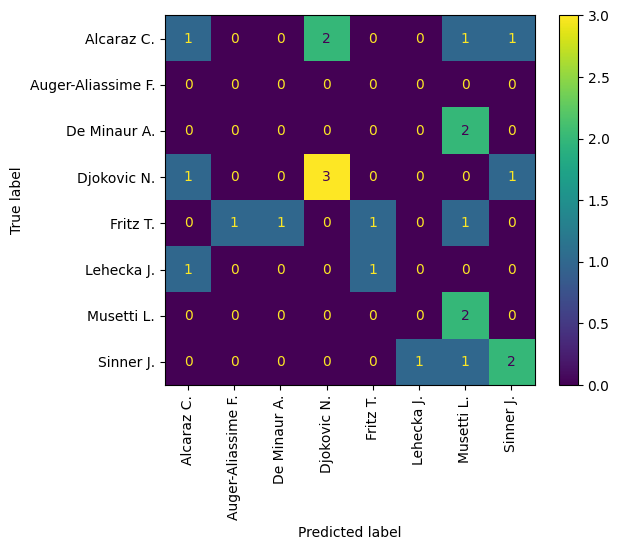

In [75]:
cm = confusion_matrix(y_test, y_pred)

# Reverse the mapping: from ID to name
id_to_player = {v: k for k, v in active_player_map.items()}

# Create a list of display labels ordered by class ID (i.e., 0 to 7)
sorted_labels = [id_to_player[i] for i in range(len(id_to_player))]

# Then use this in the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted_labels)
disp.plot(xticks_rotation='vertical')

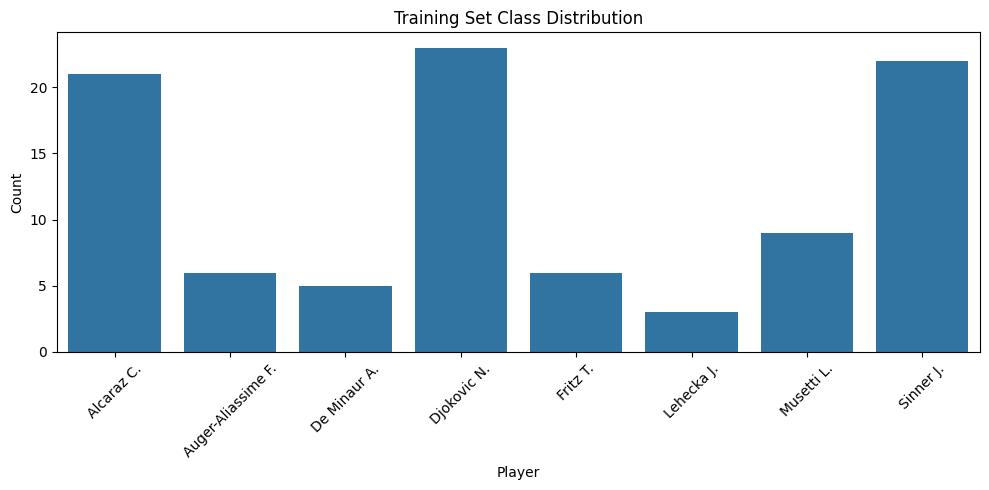

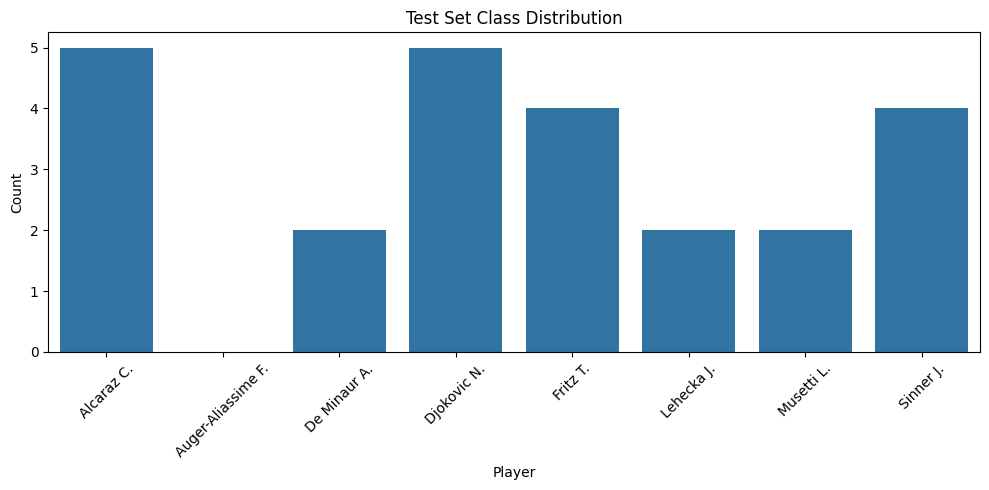

In [76]:
ordered_player_names = [id_to_player[i] for i in sorted(id_to_player.keys())]

# Map numeric labels to player names
y_train_named = y_train.map(id_to_player)
y_test_named = y_test.map(id_to_player)

# Plot training distribution
plt.figure(figsize=(10,5))
sns.countplot(x=y_train_named, order=ordered_player_names)
plt.title("Training Set Class Distribution")
plt.xlabel("Player")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot test distribution
plt.figure(figsize=(10,5))
sns.countplot(x=y_test_named, order=ordered_player_names)
plt.title("Test Set Class Distribution")
plt.xlabel("Player")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

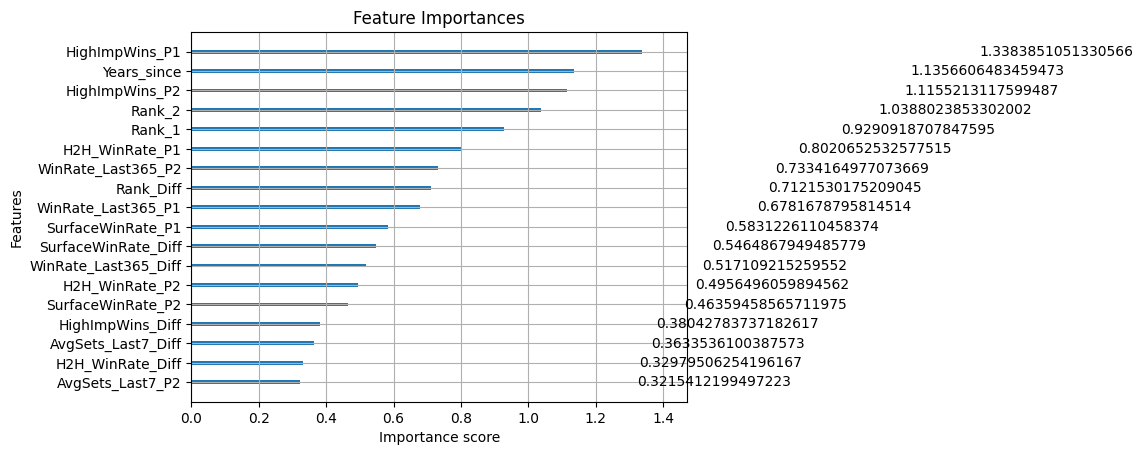

In [77]:
xgb.plot_importance(bst, importance_type='gain')
plt.title("Feature Importances")
plt.show()

Seems like it's learning some kind of pattern between Player_1 and Player_2 again...

Ok, let's simulate the matches...

In [80]:
def simulate_match(p1, p2, match_date, surface='Hard', round_name='Quarterfinals', best_of=5):
    # --- Calculate features for this match ---
    rank_1 = 999
    rank_2 = 999
    rank_1 = df_original[df_original['Player_1'] == p1]['Rank_1'].iloc[-1] if not df_original[df_original['Player_1'] == p1].empty else rank_1
    rank_2 = df_original[df_original['Player_2'] == p2]['Rank_2'].iloc[-1] if not df_original[df_original['Player_2'] == p2].empty else rank_2
    rankdiff = rank_2 - rank_1

    years_since = 2025 - match_date.year

    winrate_p1 = calc_winrate(p1, match_date)
    winrate_p2 = calc_winrate(p2, match_date)
    winrate_diff = winrate_p1 - winrate_p2
    surface_winrate_p1 = calc_surface_winrate(p1, surface)
    surface_winrate_p2 = calc_surface_winrate(p2, surface)
    surface_winrate_diff = surface_winrate_p1 - surface_winrate_p2
    avg_sets_p1 = avg_sets_last_7_days(p1, match_date)
    avg_sets_p2 = avg_sets_last_7_days(p2, match_date)
    avg_sets_diff = avg_sets_p1 - avg_sets_p2
    h2h_winrate_p1, h2h_winrate_p2 = get_head_to_head_stats(p1, p2)


    high_imp_wins_p1 = get_cumulative_wins(p1, match_date)
    high_imp_wins_p2 = get_cumulative_wins(p2, match_date)
    high_imp_wins_diff = high_imp_wins_p1 - high_imp_wins_p2

    tournament_tier = series_tier_map.get('Grand Slam', 5)
    round_val = round_value_map.get(round_name, 5)
    match_importance = tournament_tier * round_val
    num_sets = best_of

 
    # --- Create DataFrame with features ---
    row = pd.DataFrame([{
        'Rank_1': rank_1,
        'Rank_2': rank_2,
        'Rank_Diff': rankdiff,
        'Years_since': years_since,
        'WinRate_Last365_P1': winrate_p1,
        'WinRate_Last365_P2': winrate_p2,
        'WinRate_Last365_Diff': winrate_diff,
        'SurfaceWinRate_P1': surface_winrate_p1,
        'SurfaceWinRate_P2': surface_winrate_p2,
        'SurfaceWinRate_Diff': surface_winrate_diff,
        'HighImpWins_P1': high_imp_wins_p1,
        'HighImpWins_P2': high_imp_wins_p2,
        'AvgSets_Last7_P1': avg_sets_p1,
        'AvgSets_Last7_P2': avg_sets_p2,
        'AvgSets_Last7_Diff': avg_sets_diff,
        'H2H_WinRate_P1': h2h_winrate_p1,
        'H2H_WinRate_P2': h2h_winrate_p2,
        'H2H_WinRate_Diff': h2h_winrate_p1 - h2h_winrate_p2,
        'HighImpWins_Diff': high_imp_wins_diff
    }])

    core_scaler = joblib.load('scalers/core_features_scaler.pkl')

    row[['HighImpWins_P1', 'HighImpWins_P2', 'HighImpWins_Diff', 'Years_since']] = core_scaler.transform(
    row[['HighImpWins_P1', 'HighImpWins_P2', 'HighImpWins_Diff','Years_since']]
)

    # --- Print feature inputs for debugging ---
    print(f"\nFeatures for {p1} vs {p2}:")
    for col in row.columns:
        print(f"  {col}: {row[col].iloc[0]}")
    

    dmatch = xgb.DMatrix(row[feature_cols])

    # Map player names to indices
    p1_idx = active_player_map[p1]
    p2_idx = active_player_map[p2]

    # Adjusting probabilities
    logits = bst.predict(dmatch, output_margin=True)[0]  # raw scores before sigmoid 
    temperature = 2.5
    score_diff = (logits[p1_idx] - logits[p2_idx]) / temperature
    p1_prob = 1 / (1 + np.exp(-score_diff))  # Sigmoid
    p2_prob = 1 - p1_prob

    print(f"🔍 Probabilities for {p1} vs {p2}:")
    print(f"→ {p1}: {p1_prob * 100:.2f}%")
    print(f"→ {p2}: {p2_prob * 100:.2f}%")

    # Predict winner based on higher probability
    predicted_winner = p1 if p1_prob > p2_prob else p2
    loser = p2 if predicted_winner == p1 else p1

    # --- Update history dicts (important!) ---
    did_p1_win = int(predicted_winner == p1)
    did_p2_win = int(predicted_winner == p2)

    # Update match history
    player_matches[p1].append((match_date, p2, did_p1_win, rank_2, num_sets))
    player_matches[p2].append((match_date, p1, did_p2_win, rank_1, num_sets))

    # Update surface stats
    for player, did_win in [(p1, did_p1_win), (p2, did_p2_win)]:
        if surface not in player_surface_stats[player]:
            player_surface_stats[player][surface] = [0, 0]
        player_surface_stats[player][surface][0] += did_win
        player_surface_stats[player][surface][1] += 1
    
    initialize_head_to_head(df_original)

    # Update H2H
    update_head_to_head(p1, p2, predicted_winner)

    # Update high importance wins
    if match_importance > importance_threshold:
        player_high_importance_wins[predicted_winner].append(match_date)

    return predicted_winner

def run_us_open_simulation():
    current_date = pd.to_datetime("2025-9-2")
    surface = "Hard"
    best_of = 5

    print("Quarterfinals")
    qf_matches = [
        ("Alcaraz C.", "Lehecka J."),
        ("Djokovic N.", "Fritz T."),
        ("Sinner J.", "Musetti L."),
        ("De Minaur A.", "Auger-Aliassime F.")
    ]

    qf_winners = []
    for p1, p2 in qf_matches:
        winner = simulate_match(p1, p2, current_date, surface, 'Quarterfinals', best_of)
        print(f"{p1} vs {p2} → Winner: {winner}")
        qf_winners.append(winner)

    print("\nSemifinals")
    sf_matches = [
        (qf_winners[0], qf_winners[1]),
        (qf_winners[2], qf_winners[3])
    ]

    sf_winners = []
    for p1, p2 in sf_matches:
        winner = simulate_match(p1, p2, current_date + pd.Timedelta(days=2), surface, 'Semifinals', best_of)
        print(f"{p1} vs {p2} → Winner: {winner}")
        sf_winners.append(winner)

    print("\nFinal")
    final_winner = simulate_match(
        sf_winners[0], sf_winners[1], current_date + pd.Timedelta(days=4), surface, 'The Final', best_of
    )
    print(f"Final: {sf_winners[0]} vs {sf_winners[1]} → Champion: {final_winner}")

    return final_winner



In [81]:
champion = run_us_open_simulation()

Quarterfinals

Features for Alcaraz C. vs Lehecka J.:
  Rank_1: 2
  Rank_2: 27
  Rank_Diff: 25
  Years_since: 0.0
  WinRate_Last365_P1: 0.7272727272727273
  WinRate_Last365_P2: 0.25
  WinRate_Last365_Diff: 0.4772727272727273
  SurfaceWinRate_P1: 0.5
  SurfaceWinRate_P2: 0.2
  SurfaceWinRate_Diff: 0.3
  HighImpWins_P1: 1.0
  HighImpWins_P2: 0.0
  AvgSets_Last7_P1: 0.0
  AvgSets_Last7_P2: 0.0
  AvgSets_Last7_Diff: 0.0
  H2H_WinRate_P1: 0.6666666666666666
  H2H_WinRate_P2: 0.3333333333333333
  H2H_WinRate_Diff: 0.3333333333333333
  HighImpWins_Diff: 1.2083333333333333
🔍 Probabilities for Alcaraz C. vs Lehecka J.:
→ Alcaraz C.: 76.32%
→ Lehecka J.: 23.68%
Alcaraz C. vs Lehecka J. → Winner: Alcaraz C.

Features for Djokovic N. vs Fritz T.:
  Rank_1: 6
  Rank_2: 7
  Rank_Diff: 1
  Years_since: 0.0
  WinRate_Last365_P1: 0.6666666666666666
  WinRate_Last365_P2: 0.6666666666666666
  WinRate_Last365_Diff: 0.0
  SurfaceWinRate_P1: 0.8
  SurfaceWinRate_P2: 0.2
  SurfaceWinRate_Diff: 0.600000000000

Woah. So, it actually got the De Minaur v. Auger-Aliassime match right and the predictions seem more balanced. I guess since I'm using the model in the simulation for only 1v1 it is more accurate since it is easier to get only two predictions, but when it has to predict over all the 8 classes, it is not as accurate. 

Overall, I've realized that maybe viewing this as a multiclass classification problem was not the right way to go about it since ultimately it is a binary classification problem about who won each match. In the future I would change my model to be a binary classifier. I'm still confused about how it would learn information about all of the active players though if it was only focusing on the outcome of each match. I guess over time it would learn about my players after learning about their wins and losses. I'm glad I learned something about multiclass probabilities and the XGBoost model.

To be explored further in the future...